<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [2]:
#URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [3]:
import requests
import bs4
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook

In [5]:
grab = requests.get(URL)
soup = BeautifulSoup(grab.text,'html.parser')

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [306]:
def extract_jobtitle_from_result(result):
    try:
        return result.find('a',attrs={'class':'jobtitle'})['title']
        
    except:
        
        return np.nan

def extract_location_from_result(result):    
    try:
        return result.find('span',attrs={'class':'location accessible-contrast-color-location'}).text
    
    except:
        
        return np.nan
        
def extract_salary_from_result(result):
    try:
        return result.find('span',attrs={'class':"salaryText"}).text.strip()
        
    except:
        
        return np.nan

def extract_company_from_result(result):
    try:
        return result.find('span',attrs={'class':"company"}).text.strip()
        
    except:
        return np.nan
    
def extract_summary_from_result(result):
    try:
        return result.find('div',attrs={'class':re.compile(r'^jobsearch-jobDescriptionText?')})
        
    except:
        return np.nan
    
def extract_href_from_result(result):
    try:
        return result.find('a')['href']
        
    except:
        return np.nan

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [790]:
states_to_use = ["Alabama","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Missouri","Montana","Nevada","New Hampshire","New Jersey",
"New Mexico","New York","North Carolina","Ohio","Oregon","Pennsylvania",
  "Rhode Island","Tennessee","Texas","Utah","Virginia","Washington","Wisconsin"]

list_of_searchwords = ['data+scientist','data+analyst','research+scientist','business+intelligence','machine+learning']

In [791]:
jobs_in_state = {'state':[],'role':[],'jobs':[]}

for state in tqdm_notebook(states_to_use):
    
    for role in list_of_searchwords:
    

        count_url = f'https://www.indeed.com/jobs?as_ttl={role}&l={state}&radius=5000&fromage=any&limit=50&start=0&filter=0'

        time.sleep(np.random.randint(0,2))

        counter = requests.get(count_url)
        soup_count = BeautifulSoup(counter.text,'html.parser')

        try:
            record_string = soup_count.find_all('div',attrs={'id':"searchCountPages"})[0].text
            record_string = record_string.replace(",","")
            max_results_per_city = int(re.search(r"(\w+)\sjobs",record_string).group(1))
            
        except:
            max_results_per_city = np.nan
            
        try:
            true_pages = int(soup_count.find_all("span",class_="pn")[-2].text)
            #print(true_pages,max_results_per_city)
            
        except:
            true_pages = 0
            #print(true_pages)

        jobs_in_state['state'].append(state)
        jobs_in_state['role'].append(role)
        jobs_in_state['jobs'].append(max_results_per_city)    

In [823]:
job_nums = pd.DataFrame(jobs_in_state).sort_values(by='jobs',ascending=False)
state_searchlist = list(job_nums.groupby(["state"]).mean().sort_values(by="jobs",ascending=True).index)
role_searchlist = list(job_nums.groupby(["role"]).mean().sort_values(by="jobs",ascending=True).index)

In [824]:
job_nums[job_nums.jobs.isna()]

,state,role,jobs


In [883]:
df_dict = {'job_title':[],'job_category':[],
           'company':[],'location':[],
           'region':[],'salary':[],
           'link':[],'summary':[]}

#url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 294 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

all_files = []

for state in tqdm_notebook(state_searchlist[30:42]):

    for role in tqdm_notebook(role_searchlist):
        
        count_url = f'https://www.indeed.com/jobs?as_ttl={role}&l={state}&radius=5000&fromage=any&limit=50&start=0&filter=0'

        time.sleep(np.random.randint(0,1))

        counter = requests.get(count_url)
        soup_count = BeautifulSoup(counter.text,'html.parser')

        try:
            record_string = soup_count.find_all('div',attrs={'id':"searchCountPages"})[0].text
            record_string = record_string.replace(",","")
            max_results_per_city = int(re.search(r"(\w+)\sjobs",record_string).group(1))
        except:
            max_results_per_city = 1
         
        for start in tqdm_notebook(range(0, max_results_per_city,50)):
            time.sleep(np.random.randint(0,1))
            
            URL = f'https://www.indeed.com/jobs?as_ttl={role}&l={state}&radius=5000&fromage=any&limit=50&start={start}&filter=0'
            
            results = requests.get(URL)
            soup = BeautifulSoup(results.text,'html.parser')
                        
            #print(city,int(max_results_per_city))
            
            #print(state,start,soup.find_all('div',attrs={'id':"searchCountPages"})[0].text)
            
            if len(soup.find_all('span',attrs={'class':'salary no-wrap'})) == 0:
                
                pass
                
            else:
                for jobtile in soup.find_all('div',attrs={'class':re.compile(r'^jobsearch-Serp.*unified.*')}):

                    if len(jobtile.find_all('span',attrs={'class':'salary no-wrap'})) == 0:
                        pass
                    else:
                        all_files.append(jobtile)
                        df_dict['job_category'].append(" ".join(role.split("+")).title())
                        df_dict['region'].append(" ".join(state.split("+")).title())
                        
                        detail_link = "https://indeed.com/"+extract_href_from_result(jobtile)
                        df_dict['link'].append(detail_link)
                        time.sleep(np.random.randint(0,1))
                        detailgrab = requests.get(detail_link)
                        soup_detail = BeautifulSoup(detailgrab.text,'html.parser')
                        
                        try:
                            df_dict['summary'].append(extract_summary_from_result(soup_detail).text)
                        except:
                            df_dict['summary'].append(np.nan)

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [887]:
for x in all_files:
    try:
        df_dict['location'].append(extract_location_from_result(x))
    except:
        df_dict['location'].append(np.nan)
        
    try:
        df_dict['company'].append(extract_company_from_result(x))
    except:
        df_dict['company'].append(np.nan)
        
    try:
        df_dict['salary'].append(extract_salary_from_result(x))
        
    except:
        df_dict['salary'].append(np.nan)

    try:
        df_dict['job_title'].append(extract_jobtitle_from_result(x))
        
    except:
        df_dict['job_title'].append(np.nan)

In [1663]:
df = pd.DataFrame(df_dict)

np.sum(df[df.salary.notna()].duplicated() ==False)*100/df.shape[0]

#df = df[df.salary.notna()]

#df = df[df.duplicated()==False]

#df.to_csv("us_jobs_40.csv",index=False)

89.5784543325527

### [Click here for Webscrape code for other countries](./other/global_job_numbers.ipynb)

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [5]:
import re
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 50)

#Loading US salary csv's from web scraping and concatenating
df_us1 = pd.read_csv("./webscraping/us_jobs_10.csv")
df_us2 = pd.read_csv("./webscraping/us_jobs_20.csv")
df_us3 = pd.read_csv("./webscraping/us_jobs_30.csv")
df_us4 = pd.read_csv("./webscraping/us_jobs_40.csv")
df_usa = pd.concat([df_us1,df_us2,df_us3,df_us4])

#Loading UK, Australia and Canada salary csv's from web scraping
df_uk = pd.read_csv("./webscraping/uk_jobs.csv")
df_aus = pd.read_csv("./webscraping/aus_jobs.csv")
df_can = pd.read_csv("./webscraping/can_jobs.csv")

In [6]:
#Setting country and exchange rate for UK
df_uk['country'] = "United Kingdom"
df_uk['exch_rate'] = 1

In [7]:
#Using currency API to grab exchange rate dictionary for current figures
currency_url = 'https://api.exchangeratesapi.io/latest'
exch_rate_dict = requests.get(currency_url,params={"base":"GBP"}).json()

In [8]:
#Setting country and exchange rate for Canada, US, Australia
df_can['country'] = "Canada"
df_can['exch_rate'] = exch_rate_dict['rates']['CAD']

df_usa['country'] = "United States"
df_usa['exch_rate'] = exch_rate_dict['rates']['USD']

df_aus['country'] = "Australia"
df_aus['exch_rate'] = exch_rate_dict['rates']['AUD']

In [9]:
# Concatenating new dataframes and saving in global csv
df = pd.concat([df_usa,df_uk,df_aus,df_can])
df.to_csv("./webscraping/global_jobs_all.csv",index=False)

In [10]:
#Dropping records with no salary information
df = df[df.salary.notna()]

#Removing dupplicates
df = df[df.duplicated()==False]
df['pay_rate'] = df.salary.apply(lambda x: 1 if "year" in x 
                             else 12 if "month" in x 
                             else 40*52 if "hour" in x 
                             else 52 if "week" in x 
                             else 5*52 if "day" in x else x)

df.shape

(3056, 11)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [11]:
#Creating function to split lower and upper salary range, deterimine the median salary and calculate the equivalent
# annual salary adjusted for currency exchange rates
def salary_adj(df):
    
    df['lower'] = df.salary.apply(lambda x: x.split("-")[0])

    df['upper'] = df.salary.apply(lambda x: x.split("-")[1] if len(x.split("-"))==2 else x.split("-")[0])
    df['lower'] = df.lower.apply(lambda x: eval(re.search(r"[\d|.]+",x.replace("$","").replace(",","")).group()))
    df['upper'] = df.upper.apply(lambda x: eval(re.search(r"[\d|.]+",x.replace("$","").replace(",","")).group()))

    df['median_salary'] = (df.lower+df.upper)/2
    df['equivalent_salary'] = df.pay_rate*df['median_salary']/df.exch_rate
    
    return df.reset_index(drop=True)

In [12]:
#Using keywords to define the job level in the dataset
def job_level(df):
    
    df["level"] = df.job_title.apply(lambda x: "Lead" if "lead" in x.lower() 
                                     else "Senior" if ("senior" in x.lower()  or "sr" in x.lower() or "master" in x.lower())
                                     else "Principal" if "principal" in x.lower()
                                     else "Mid" if "mid" in x.lower() 
                                     else "Junior" if ("junior" in x.lower()  
                                                       or "jr" in x.lower()  
                                                       or "entry" in x.lower() 
                                                       or "level 4" in x.lower() 
                                                       or 'apprentice' in x.lower() 
                                                       or'intern' in x.lower() 
                                                       or 'trainee' in x.lower() 
                                                       or 'student' in x.lower() or 'graduate' in x.lower())
                                     else "Mid")
    return df

In [13]:
df = salary_adj(df)

df = job_level(df)

df.summary = df.summary.astype(str)

In [14]:
#Segmenting into Regions for the USA
west_usa = ['Alaska','Arizona','California','Colorado','Hawaii','Idaho','Montana','Nevada','New Mexico','Oregon','Utah','Washington','Wyoming']
midwest_usa = ['Illinois','Indiana','Iowa','Kansas','Michigan','Missouri','Minnesota','Nebraska','North Dakota','Ohio','South Dakota','Wisconsin']
south_usa = ['Alabama','Arkansas','Delaware','Florida','Georgia','Kentucky','Louisiana','Maryland','Mississippi','Oklahoma','North Carolina','South Carolina',
'Tennessee','Texas','Virginia','West Virginia']
northeast_usa = ['Connecticut','Maine','New Hampshire','Massachusetts','New Jersey','New York','Pennsylvania','Rhode Island','Vermont']

In [15]:
df.region = df.region.apply(lambda x : 'West' if x in west_usa
               else 'MidWest' if x in midwest_usa
               else 'South' if x in south_usa
               else 'NorthEast' if x in northeast_usa
               else x)

In [16]:
pd.set_option('display.max_colwidth',100)
df[(df.level == 'Mid')&(df.equivalent_salary<10000)][df[(df.level == 'Mid')&(df.equivalent_salary<10000)]['job_title'].str.contains("")]

,job_title,job_category,company,location,region,salary,link,summary,country,exch_rate,pay_rate,lower,upper,median_salary,equivalent_salary,level
1247,GeMS Research Scientist,Research Scientist,Your World Healthcare,London,England,£28 - £35 a day,https://www.indeed.co.uk//rc/clk?jk=de931820569b9984&fccid=69cccacd95d597d1&vjs=3,This Biomedical Science position is suitable for a qualified Biomedical Scientist to apply on a ...,United Kingdom,1.0,260,28.0,35.0,31.5,8190.0,Mid
2166,Data Scientist SC Cleared,Data Scientist,Hydrogen Group,London,England,£640 a month,https://www.indeed.co.uk//rc/clk?jk=d2d51c0abb2bf022&fccid=251eba8a83187770&vjs=3,Data Scientist with current SC Clearance - London - Contract\n\nDay Rate: Up to £640\nLocation: ...,United Kingdom,1.0,12,640.0,640.0,640.0,7680.0,Mid
2194,Data Scientist,Data Scientist,J&C Associates Ltd,London,England,£600 - £700 a month,https://www.indeed.co.uk//rc/clk?jk=449bf9be0fd6743e&fccid=8ff70a8dd021e453&vjs=3,"London, England\nSalary: £600 - £700\nposted on 03.04.19\n\nSenior Scientist - London\nWhat will...",United Kingdom,1.0,12,600.0,700.0,650.0,7800.0,Mid
2195,Data Scientist,Data Scientist,J&C Associates Ltd,London,England,£600 - £700 a month,https://www.indeed.co.uk//rc/clk?jk=34ba8a200ea42999&fccid=8ff70a8dd021e453&vjs=3,"London, England\nSalary: £600 - £700\nposted on 03.04.19\n\nSenior Data Scientist - London\nWhat...",United Kingdom,1.0,12,600.0,700.0,650.0,7800.0,Mid
2443,Lambeth Youth Violence Data Analyst,Data Analyst,SW Locums,London,England,£25 a day,https://www.indeed.co.uk//rc/clk?jk=7dcc119e929f1a12&fccid=cbbdee7fe5f8b1a9&vjs=3,"SW Locums are looking for Youth Violence Data Analyst. The role is to source, collect, analyse a...",United Kingdom,1.0,260,25.0,25.0,25.0,6500.0,Mid


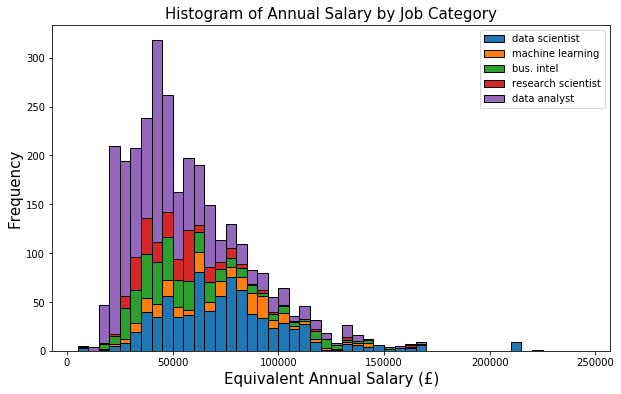

In [130]:
df2 = df[['job_title','job_category','company','location','region','equivalent_salary','level','summary','country']]

plt.figure(figsize=(10,6))
#sns.distplot(df2.equivalent_salary,bins=range(5000,250000,5000),kde=False,hist_kws=dict(ec='k'),color='r',label='data related role')
plt.title("Histogram of Annual Salary by Job Category",fontsize=15)
plt.xlabel("Equivalent Annual Salary (£)",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

d_scient = df2[df2['job_category'] == 'Data Scientist']['equivalent_salary']
d_analyst = df2[df2['job_category'] == 'Data Analyst']['equivalent_salary']
m_learning = df2[df2['job_category'] == 'Machine Learning']['equivalent_salary']
b_intel = df2[df2['job_category'] == 'Business Intelligence']['equivalent_salary']
r_scient = df2[df2['job_category'] == 'Research Scientist']['equivalent_salary']
level_labels = ['data scientist','machine learning','bus. intel','research scientist','data analyst']

plt.hist([d_scient,m_learning,b_intel,r_scient,d_analyst],bins=range(5000,250000,5000),ec='k',label=level_labels,stacked=True)

#df2[df2['job_category'] == 'Data Scientist']['equivalent_salary'].hist(bins=range(5000,250000,5000),ec='k',label='data scientist',alpha=0.75)
plt.legend()
plt.savefig("./images/data_science.png");

In [123]:
junior_level.label = 'junior-level'

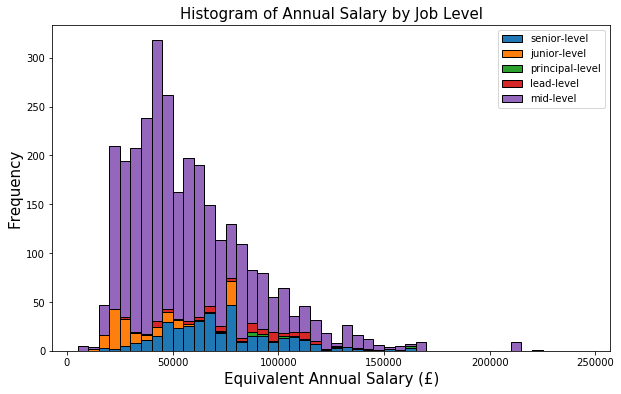

In [134]:
plt.figure(figsize=(10,6))
plt.xlabel("Equivalent Annual Salary (£)",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Histogram of Annual Salary by Job Level",fontsize=15)

junior_level = df2[df2['level'] == 'Junior']['equivalent_salary']
senior_level = df2[df2['level'] == 'Senior']['equivalent_salary']
mid_level = df2[df2['level'] == 'Mid']['equivalent_salary']
princ_level = df2[df2['level'] == 'Principal']['equivalent_salary']
lead_level = df2[df2['level'] == 'Lead']['equivalent_salary']
level_labels = ['senior-level','junior-level','principal-level','lead-level','mid-level']

plt.hist([senior_level,junior_level,princ_level,lead_level,mid_level],bins=range(5000,250000,5000),ec='k',label=level_labels,stacked=True)
plt.legend()
plt.savefig("./images/level.png");

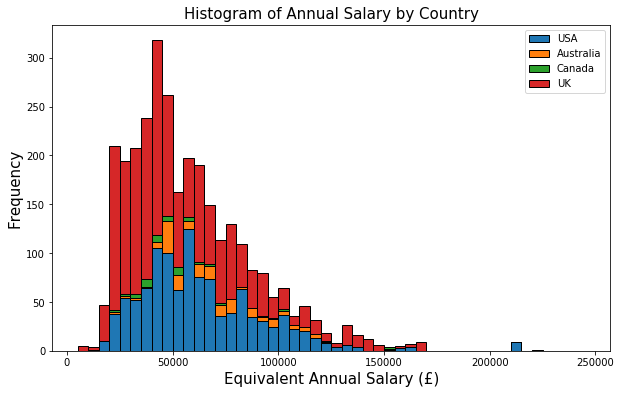

In [132]:
plt.figure(figsize=(10,6))
plt.xlabel("Equivalent Annual Salary (£)",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Histogram of Annual Salary by Country",fontsize=15)

aus_ctry = df2[df2['country'] == 'Australia']['equivalent_salary']
usa_ctry = df2[df2['country'] == 'United States']['equivalent_salary']
uk_ctry = df2[df2['country'] == 'United Kingdom']['equivalent_salary']
can_ctry = df2[df2['country'] == 'Canada']['equivalent_salary']
level_labels = ['USA','Australia','Canada','UK']

plt.hist([usa_ctry,aus_ctry,can_ctry,uk_ctry],bins=range(5000,250000,5000),ec='k',label=level_labels,stacked=True)
plt.legend()
plt.savefig("./images/country.png");

In [126]:
df2.region.unique()

array(['West', 'NorthEast', 'South', 'MidWest', 'Northern Ireland',
       'Wales', 'Scotland', 'England', 'South Australia',
       'Western Australia', 'Queensland', 'Victoria', 'New South Wales',
       'Saskatchewan', 'Nova Scotia', 'Manitoba', 'Alberta',
       'British Columbia', 'Quebec', 'Ontario'], dtype=object)

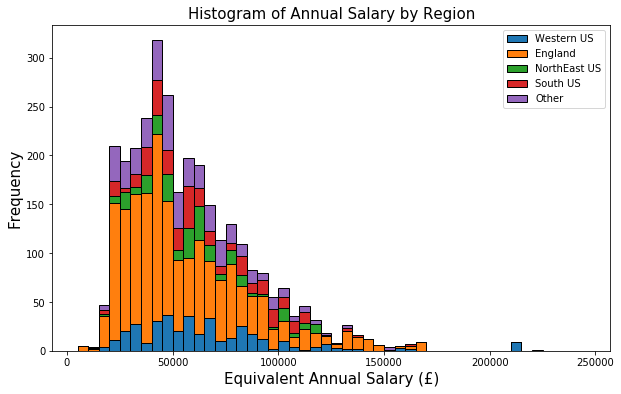

In [133]:
plt.figure(figsize=(10,6))
plt.xlabel("Equivalent Annual Salary (£)",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Histogram of Annual Salary by Region",fontsize=15)

west_region = df2[df2['region'] == 'West']['equivalent_salary']
eng_region = df2[df2['region'] == 'England']['equivalent_salary']
neast_region = df2[df2['region'] == 'NorthEast']['equivalent_salary']
south_region = df2[df2['region'] == 'South']['equivalent_salary']
othr_region = df2[(df2['region'] != 'West')&
                  (df2['region'] != 'England')&
                  (df2['region'] != 'NorthEast')&
                  (df2['region'] != 'South')]['equivalent_salary']
level_labels = ['Western US','England','NorthEast US','South US','Other']

plt.hist([west_region,eng_region,neast_region,south_region,othr_region],bins=range(5000,250000,5000),ec='k',label=level_labels,stacked=True)
plt.legend()
plt.savefig("./images/region.png");

In [2605]:
df2[(df2.job_title.str.contains("Junior"))&(df2.job_category == "Data Scientist")]

,job_title,job_category,company,location,region,equivalent_salary,level,summary
635,Junior Data Scientist - Client Technical Specialist,Data Scientist,IBM,"Austin, TX 78758 (North Austin area)",South,70170.343026,Junior,"Are you a Junior Data Scientist with experience in Machine Learning, Optimization, Neural Networ..."
857,Junior Data Scientist - New York City,Data Scientist,IBM,"New York, NY 10001 (Chelsea area)",NorthEast,77967.047807,Junior,"Are you a Junior Data Scientist with experience in Machine Learning, Optimization, Neural Networ..."
1148,Junior Data Scientist,Data Scientist,Concept Information Technology,Cardiff,Wales,39000.000000,Junior,My client are government body based in Cardiff. They're seeking a Data Scientist on a 6 month co...
1724,Junior Data Scientist,Data Scientist,Oscar Technology,England,England,45000.500000,Junior,If you have a passion for using and want to apply an array of analytical tools to develop new pr...
1727,Junior Data Scientist,Data Scientist,Harnham,London,England,62500.000000,Junior,"Junior Data Scientist\nFTSE 250 Company\nLondon\n£60,000\nTHE COMPANY\nThe Harnham Data Science ..."
1745,Junior Data Scientist,Data Scientist,Harnham,London,England,52500.000000,Junior,"JUNIOR DATA SCIENTIST £50,000-£60,000 + COMPETITIVE BENEFITS\nCENTRAL LONDON\nAre you looking fo..."
1794,Junior Data Scientist,Data Scientist,Unitemps,Stoke-on-Trent,England,22500.000000,Junior,Based in Stoke on Trent this industry leading retail solutions business is looking to recruit a ...
1824,Junior Python Data Engineer / Data Scientist,Data Scientist,Bettor Believe,London,England,40000.000000,Junior,We are looking for a talented developer with a strong mathematical and statistical background to...
1854,Junior Data Scientist,Data Scientist,Harnham,London,England,60500.000000,Junior,"Junior Data Scientist\nLondon, United Kingdom\nSalary up to £60,000 + Benefits\nJunior Data Scie..."
2048,"Junior Data Scientist- Machine Learning, Python, C++, Data Analytics",Data Scientist,ZenShin Talent,Cambridge,England,42500.000000,Junior,"Junior Data Scientist- Machine Learning, Python, C++, Big Data Technologies, Analytics and Data ..."


### Save your results as a CSV

In [129]:
df.to_csv("classification_data.csv",index=False)
df.to_excel("classification_data.xls",index=False)

# [Go to Part 2 of Project by clicking this link!](project-04-charles-denbow-part-2.ipynb)